<a href="https://colab.research.google.com/github/Anenmi/practice/blob/main/Sbermarket_Competition_Prediction_of_Buying_the_Cart_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Импорты

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline 

In [2]:
import datetime
from pandas.tseries.offsets import DateOffset
import holidays

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 18 13:14:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/train.csv")
data.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


In [7]:
data['order_completed_at'] = pd.to_datetime(data['order_completed_at'])
#data.info()

# 1. Анализ данных

In [8]:
USER_UNQ_QNT = data['user_id'].nunique()
CART_UNQ_QNT = data['cart'].nunique()
ORDER_UNQ_QNT = data.loc[:, ('user_id','order_completed_at')].drop_duplicates().shape[0]

day_time_format = "%Y-%m-%d"
START_DAY = data['order_completed_at'].min()
END_DAY = data['order_completed_at'].max()

print (f'Уникальных клиентов в выборке: {USER_UNQ_QNT}\n')
print (f'Уникальных категорий: {CART_UNQ_QNT}\n')
print (f'Всего заказов: {ORDER_UNQ_QNT}\n')
print (f'Временной промежуток: {START_DAY:{day_time_format}} - {END_DAY:{day_time_format}}')

Уникальных клиентов в выборке: 20000

Уникальных категорий: 881

Всего заказов: 209406

Временной промежуток: 2015-03-22 - 2020-09-03


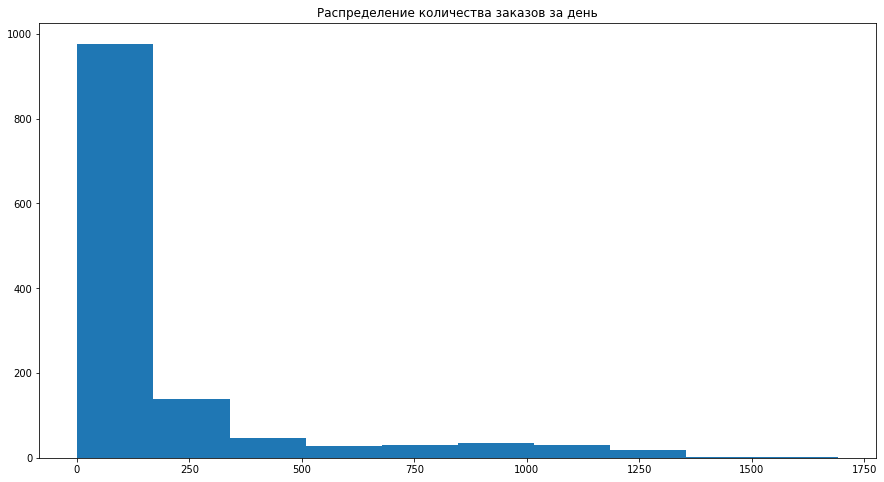

In [9]:
# Сколько заказов совршалось в день
data4plt = data.loc[:, ('user_id','order_completed_at')]
data4plt['order_completed_at'] = data4plt['order_completed_at'].apply(lambda x: x.date())
data4plt = data4plt.drop_duplicates().groupby('order_completed_at', as_index=False).agg({'user_id':'count'} )

plt.figure(figsize=(15,8))
plt.hist(data4plt['user_id'], bins=10)
plt.title('Распределение количества заказов за день')
plt.show()

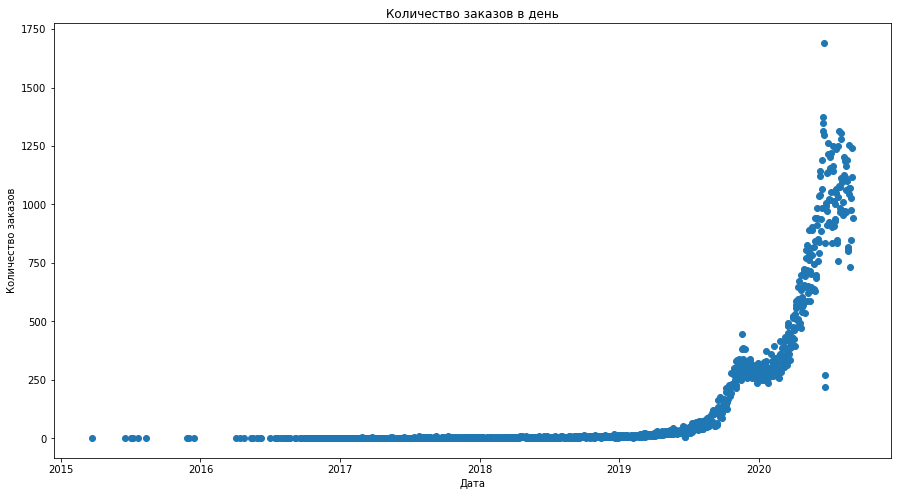

In [10]:
# Сколько заказов совршалось в день
x = data4plt['order_completed_at'] 
y = data4plt['user_id'] 

plt.figure(figsize=(15,8))
plt.scatter(x,y)
plt.title('Количество заказов в день')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

Максимальное количество раз клиенты заказывали категорию 57 - 108877 раз

Есть категории, которые присутствовали в заказах только 1 раз, таких категорий 78 штук

В среднем одну категорию заказывают 3544 раз

Медиана количества заказов категории - 66



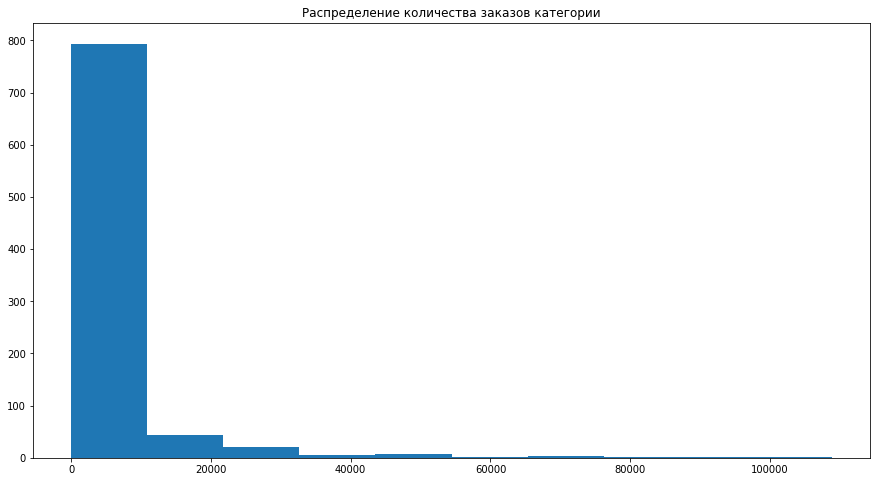

In [11]:
# Сколько раз заказывали каждую категорию
data_agg_cart = data.groupby(['cart'], as_index=False)\
                .agg({'user_id':'count'})\
                .sort_values('cart')\
                .rename(columns={'user_id':'cart_num_order'})

CART_MAX_ORDER = data_agg_cart[data_agg_cart['cart_num_order']==data_agg_cart['cart_num_order'].max()]  
CART_MIN_ORDER = data_agg_cart[data_agg_cart['cart_num_order']==data_agg_cart['cart_num_order'].min()] 
CART_MEAN_ORDER = int(data_agg_cart['cart_num_order'].mean())
CART_MEDIAN_ORDER = int(data_agg_cart['cart_num_order'].median())

print ('Максимальное количество раз клиенты заказывали категорию {0} - {1} раз\n'.format(CART_MAX_ORDER.iloc[0,0],CART_MAX_ORDER.iloc[0,1]))
print ('Есть категории, которые присутствовали в заказах только 1 раз, таких категорий {0} штук\n'.format(CART_MIN_ORDER.shape[0]))
print (f'В среднем одну категорию заказывают {CART_MEAN_ORDER} раз\n')
print (f'Медиана количества заказов категории - {CART_MEDIAN_ORDER }\n')

plt.figure(figsize=(15,8))
plt.hist(data_agg_cart['cart_num_order'], bins=10)
plt.title('Распределение количества заказов категории')
plt.show()

Максимальное количество заказов сделал клиент 2196 - 213 раз

Есть клиенты, которые сделали только 1 заказ - таких клиентов 4038 человек

В среднем клиенты сделали 10 заказов

Медиана количества заказов на клиента - 6



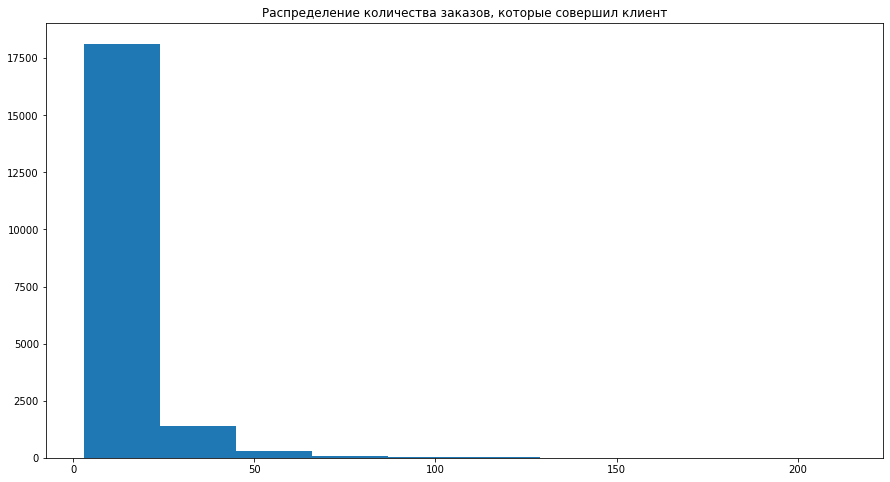

In [12]:
# Сколько заказов совершил каждый клиент
data_agg_client = data.loc[:,('user_id','order_completed_at')]\
                  .drop_duplicates()\
                  .groupby(['user_id'], as_index=False)\
                  .agg({'order_completed_at':'count'})\
                  .sort_values('user_id',  ascending=True)\
                  .rename(columns={'order_completed_at':'client_num_order'}) 

CLIENT_MAX_ORDER = data_agg_client[data_agg_client['client_num_order']==data_agg_client['client_num_order'].max()]  
CLIENT_MIN_ORDER = data_agg_client[data_agg_client['client_num_order']==data_agg_client['client_num_order'].min()] 
CLIENT_MEAN_ORDER = int(data_agg_client['client_num_order'].mean())
CLIENT_MEDIAN_ORDER = int(data_agg_client['client_num_order'].median())      

print ('Максимальное количество заказов сделал клиент {0} - {1} раз\n'.format(CLIENT_MAX_ORDER.iloc[0,0],CLIENT_MAX_ORDER.iloc[0,1]))
print ('Есть клиенты, которые сделали только 1 заказ - таких клиентов {0} человек\n'.format(CLIENT_MIN_ORDER.shape[0]))
print (f'В среднем клиенты сделали {CLIENT_MEAN_ORDER} заказов\n')
print (f'Медиана количества заказов на клиента - {CLIENT_MEDIAN_ORDER }\n')

plt.figure(figsize=(15,8))
plt.hist(data_agg_client['client_num_order'], bins=10)
plt.title('Распределение количества заказов, которые совершил клиент')
plt.show()

In [13]:
# Сколько заказов каждой категории совершил каждый клиент
client_cart_agg = data.groupby(['cart','user_id'], as_index=False)\
                        .agg({'order_completed_at':'count'})\
                        .sort_values(['cart','user_id'], ascending=False)\
                        .rename(columns={'order_completed_at':'order_cart_by_user'}) 

CLIENT_CART_MAX_ORDER = client_cart_agg[client_cart_agg['order_cart_by_user'] == client_cart_agg['order_cart_by_user'].max()]  
CLIENT_CART_MEAN_ORDER = int(client_cart_agg['order_cart_by_user'].mean())
CLIENT_CART_MEDIAN_ORDER = int(client_cart_agg['order_cart_by_user'].median())      

print ('Больше всего раз клиент {1} заказал категорию {0} - {2} раз\n'.format(CLIENT_CART_MAX_ORDER.iloc[0,0],CLIENT_CART_MAX_ORDER.iloc[0,1],CLIENT_CART_MAX_ORDER.iloc[0,2]))
print (f'В среднем клиенты заказывают категорию {CLIENT_CART_MEAN_ORDER} раза\n')
print (f'Медиана количества заказов категории на клиента - {CLIENT_CART_MEDIAN_ORDER }\n')

Больше всего раз клиент 2196 заказал категорию 57 - 196 раз

В среднем клиенты заказывают категорию 2 раза

Медиана количества заказов категории на клиента - 1



# 2. Генерация признаков
Стоит отметить, что данные транзакционные, а значит мы имеем временные зависимости и не можем использовать информацию о будущем.
- Например, мы не можем брать как признак количество заказов клиентом за все время, вместо этого нужно брать количество заказов клиентом до даты, в который был сделан очередной заказ. Так наше исследование будет ex-ante

In [14]:
df1 = data[['user_id','cart']].drop_duplicates().sort_values(['user_id'], ascending=True)
df2 = data[['user_id','order_completed_at']].drop_duplicates()
data['target'] = 1
df = df1.merge(df2, how='inner', on='user_id')\
    .merge(data, how ='left', on = ['user_id','order_completed_at','user_id','cart'])
df['target'].fillna(0, inplace=True)
df['target'] = df['target'].astype(int)
df.shape

(16966977, 4)

In [15]:
# Создам сразу тестовую выборку для отправки на kaggle
# Пока поставлю затычку, дальше просто спрогнозирую дату след. заказа
df1['order_completed_at'] = pd.Timestamp("2021/10/18")
df = pd.concat([df, df1], keys=['user_id','cart'], ignore_index=True)

In [16]:
# Прогнозируем дату следующего заказа как дата предыдущего заказа + период времени между предыдущим заказом и предпредыдущим (Тут можно улучшить обработку данных)
df.loc[df['order_completed_at'] == pd.Timestamp("2021/10/18"),'delta'] = df.sort_values('order_completed_at', ascending = True)\
                                                                        .groupby(['user_id','cart'])['order_completed_at']\
                                                                        .shift(1) - df.sort_values('order_completed_at', ascending = True)\
                                                                        .groupby(['user_id','cart'])['order_completed_at']\
                                                                        .shift(2)
df.loc[df['order_completed_at'] == pd.Timestamp("2021/10/18"),'order_completed_at'] = df.sort_values('order_completed_at', ascending = True)\
                                                                        .groupby(['user_id','cart'])['order_completed_at']\
                                                                        .shift(1) + df.delta
df.drop('delta', axis=1, inplace=True)

In [17]:
# Проверяю, что все ок
df.query('user_id==19999')

,user_id,cart,order_completed_at,target
16966974,19999,326,2020-08-31 18:54:24,1.0
16966975,19999,326,2020-08-31 19:32:08,1.0
16966976,19999,326,2020-08-31 20:08:24,1.0
18084576,19999,326,2020-08-31 20:44:40,NaN


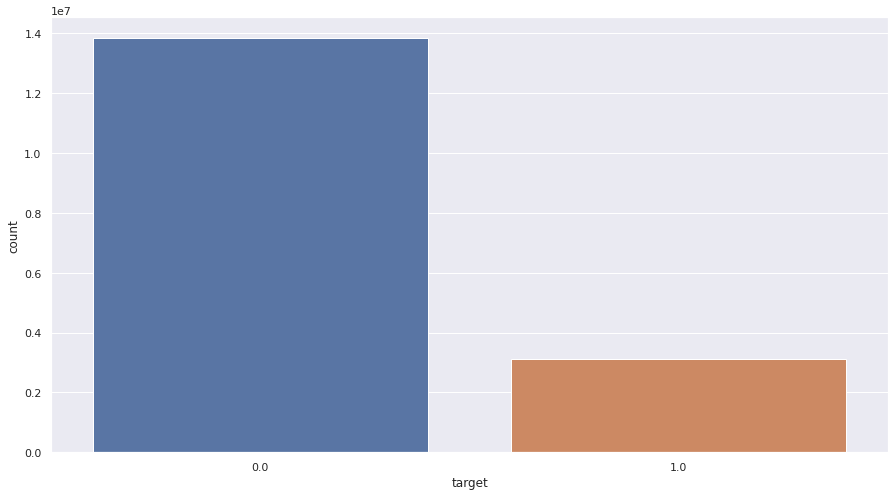

In [18]:
plt.figure(figsize=(15,8))
sns.set_theme(style="darkgrid")
sns.countplot(x='target', data=df)
plt.show()

## 2.1 Временные признаки
___
1. **order_season_cat** - сезон, 1 - зима, 2 - весна, 3 - лето, 4 - осень
1. **order_month_int** - упорядоченный месяц в формате YYYYMM, когда был сделан заказ
1. **order_hour_int** - час, в котором был сделан заказ (целое число от 0 до 23)
1. **order_is_morning** - 1, если заказ сделан до 11 утра, иначе - 0
1. **client_cart_first_order_day_int** - упорядоченный месяц в формате YYYYMM, когда был сделан первый заказ категории клиентом
1. **order_weekday_cat** - день недели заказа от 0 до 6
1. **order_is_weekend** - 1, если заказ сделан в выходной, иначе 0
1. **order_is_holiday** - 1, если заказ сделан в праздник, иначе 0
1. **client_cart_period** - Дата прошлого заказа - Дата первого заказа


In [19]:
# Функция, которая возвращает год + месяц в упорядоченном виде YYYYMM
def year_month(any_day):
  return 100 * any_day.year + any_day.month

In [20]:
# Генерирую дату, когда клиент в первый раз заказал категорию
df = df.merge(df\
         .query('target==1')
         .groupby(['cart','user_id'],as_index=False)\
         .agg(
              client_cart_first_order_day_date=pd.NamedAgg(column='order_completed_at', aggfunc='min')
              ),
         how='inner',
         on=['cart','user_id'])

In [21]:
df = df.merge(df\
         .query('target in (0,1)')
         .groupby(['cart','user_id'], as_index=False)\
         .agg(
              client_cart_last_order_day_date=pd.NamedAgg(column='order_completed_at', aggfunc='max')
              ),
         how='inner',
         on=['cart','user_id'])

In [22]:
# Тут я удаляю все записи, где дата заказа категории по клиенту раньше чем дата первого заказа категории клиентом. 
# Так как мы не можем прогнозировать на будущих данных
# Дальше я еще удалю строки первого заказа по клиенту, т.к. в первый заказ нет никако инфо. Но это после всей обработки даннных
df = df[df['client_cart_first_order_day_date']<=df['order_completed_at']]
df.shape

(13289445, 6)

In [23]:
# Дата прошлого заказа - Дата первого заказа
df['client_cart_period'] = df.order_completed_at - df.client_cart_first_order_day_date
df.loc[:,'client_cart_period'] = df['client_cart_period'].apply(lambda x: x.days).fillna(0).round(2)

In [24]:
# Проверяю, что все ок
df['last_order_flag'] = df.apply(lambda row: 1 if row['order_completed_at']==row['client_cart_last_order_day_date'] else 0, axis=1)
df.query('user_id==10000 & cart==384')

,user_id,cart,order_completed_at,target,client_cart_first_order_day_date,client_cart_last_order_day_date,client_cart_period,last_order_flag
13727430,10000,384,2020-03-26 05:10:11,1.0,2020-03-26 05:10:11,2020-08-22 09:07:18,0,0
13727431,10000,384,2020-05-14 20:47:11,0.0,2020-03-26 05:10:11,2020-08-22 09:07:18,49,0
13727432,10000,384,2020-06-09 19:56:44,1.0,2020-03-26 05:10:11,2020-08-22 09:07:18,75,0
13727433,10000,384,2020-07-23 18:07:38,0.0,2020-03-26 05:10:11,2020-08-22 09:07:18,119,0
13727434,10000,384,2020-08-22 09:07:18,0.0,2020-03-26 05:10:11,2020-08-22 09:07:18,149,1
13727435,10000,384,2020-09-21 00:06:58,NaN,2020-03-26 05:10:11,2020-08-22 09:07:18,178,0


In [25]:
df.drop('client_cart_last_order_day_date', axis=1, inplace=True)

In [26]:
# Генерирую категориальный признак, сезон, когда был совершен заказ
df['order_season_cat'] = df['order_completed_at']\
                          .apply(lambda x: 'winter' if  x.month < 3 else 
                                           'spring' if x.month < 6 else 
                                           'summer' if x.month < 9 else 
                                           'autumn' if x.month < 12 else 
                                           'winter')

In [27]:
# Генерирую месяц+год соверщения заказа
df['order_month_int'] = df['order_completed_at'].apply(lambda x: year_month(x))

In [28]:
# Генерирую час, в который был совершен заказ
df['order_hour_int'] = df['order_completed_at'].apply(lambda x: x.hour)

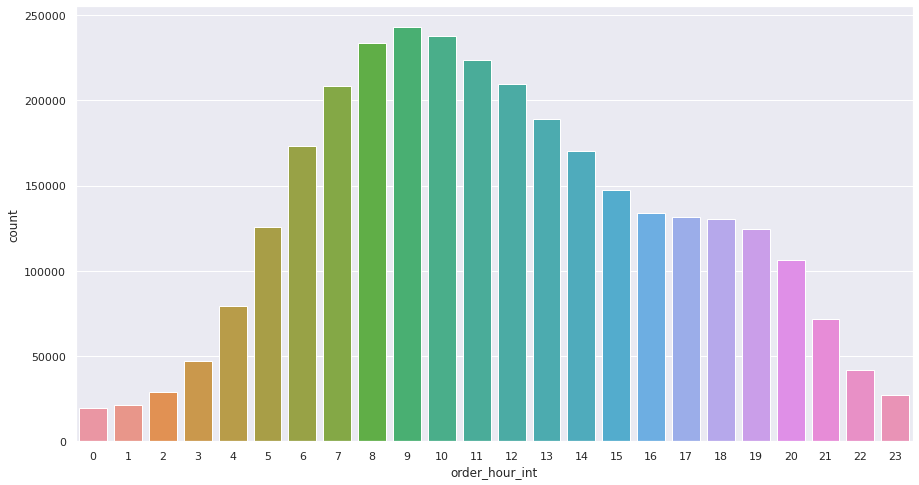

In [29]:
# Смотрим, сколько заказов было сделано в каждом час
plt.figure(figsize=(15,8))
sns.set_theme(style="darkgrid")
sns.countplot(x='order_hour_int', data=df[df['target']==1])

In [30]:
# Генерирую бинарный признак, заказ был совершен утром или нет
df['order_is_morning'] = df['order_hour_int']\
                         .apply(lambda x: 1 if x < 11 else 0)

In [31]:
# Генерирую месяц + год, когда первый раз заказали категорию
# Дату, когда клиент в первый раз заказал категорию и когда последний раз оставлю, но переименую, в будущем пригодится

df['client_cart_first_order_day_int'] = df['client_cart_first_order_day_date']\
                                        .apply(lambda x: year_month(x))

In [32]:
# Генерирую день недели, когда был совершен заказ
df['order_weekday_cat'] = df['order_completed_at']\
                          .apply(lambda x: x.weekday())

In [33]:
df['order_is_weekend'] = df['order_weekday_cat'].apply(lambda x: 1 if x == 5 else 
                                                                 1 if x == 6 else 
                                                                 0)

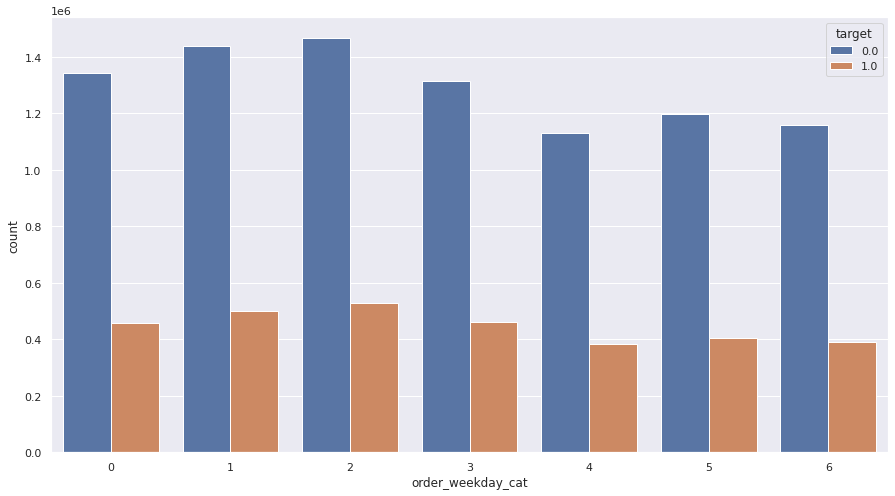

In [34]:
# Смотрим, сколько заказов было сделано в зависимости от дня недели 
plt.figure(figsize=(15,8))
sns.set_theme(style="darkgrid")
sns.countplot(x = 'order_weekday_cat', data = df, hue = 'target')

In [35]:
# Делаю атрибут, является ли день заказа предпраздничным днем или праздником, беру только крупные праздники, когда люди особенно сильно закупаются
rus_holidays = [1230, 1231, 107, 222, 223, 307, 308, 430, 501, 508, 509]

df['order_is_holiday'] = df['order_completed_at'].apply(lambda x: 1 if (100 * x.month + x.day) in rus_holidays else 0)

In [36]:
df['test_flag'] = df['target'].apply(lambda x: 1 if x != x else 0)

## 2.2 Более сложные признаки
___
1. **client_num_of_order** - Инфа, сколько клиент сделал заказов до даты заказа, считаем с первого заказа категории
1. **client_cart_num_of_order** - Инфа, сколько клиент сделал заказов категории до даты заказа, считаем с первого заказа категории
1. **lag_target** - Делал клиент заказ этой категории в прошлый раз?
1. **lag2_target** - Делал клиент заказ этой категории в позапрошлый раз?
1. **client_cart_ratio** - Сколько раз клиент заказывал категорию с первого заказа категории до даты очередного заказа
1. **client_cart_1d_qnt** - Сколько клиент покупал категорию за день в среднем за весь период с даты первого заказа категории по дату предыдущего заказа
1. **cart_qnt_in_prev_order** - Сколько cart клиент купил в предыдущем заказе
1. **is_small_prev_order** - Предыдущий заказ был маленький? (было заказано 1 - 3 категории)
1. **client_cart_1d_qnt** - Сколько клиент покупал категорию за день в среднем за весь период с даты первого заказа категории по дату предыдущего заказа
1. **mean_size_order** - Средний размер заказа за все время до даты очередного заказа
1. **orders_per_day** - Сколько клиент делал заказов в день = Количество заказов до даты очередного заказа / период с первого заказа категории до предыдущего заказа
1. **is_cart_out** - 1, если категорию не заказывали более чем пол месяца

In [37]:
# Инфа, покупал ли клиент товар в прошлый раз
df['lag_target'] = df.sort_values('order_completed_at', ascending=True).groupby(['user_id','cart'])['target'].shift(1).fillna(0).astype(int)
df['lag2_target'] = df.sort_values('order_completed_at', ascending=True).groupby(['user_id','cart'])['target'].shift(2).fillna(0).astype(int)
df['lag3_target'] = df.sort_values('order_completed_at', ascending=True).groupby(['user_id','cart'])['target'].shift(3).fillna(0).astype(int)

In [38]:
# Инфа, сколько клиент сделал заказов до даты заказа, считаем с первого закака категории
df['client_num_of_order'] = df\
                                .sort_values(['order_completed_at'], ascending=True)\
                                .groupby(['user_id','cart']).cumcount().astype(int)

In [39]:
# Инфа, сколько клиент заказывал категорию до даты заказа, считаем с первого казака категории
df['client_cart_num_of_order'] = df\
                                .sort_values(['order_completed_at'], ascending=True)\
                                .groupby(['user_id','cart'])['target'].apply(lambda x: x.shift().fillna(0).cumsum().astype(int))

In [40]:
# Отношение "сколько раз клиент купил категорию" к "сколько раз клиент делал заказ с пдаты первого заказа категории" 
df['client_cart_ratio'] = (df['client_cart_num_of_order'] / df['client_num_of_order']).fillna(0).round(4)

In [41]:
# Сколько клиент покупал категорию за год в среднем за весь период с даты первого заказа категории по дату предыдущего заказа
df['client_cart_1y_qnt'] = (df['client_cart_num_of_order'] / df['client_cart_period'] * 365).fillna(0).round(4)
df.replace([np.inf, -np.inf], 0, inplace=True)

In [42]:
# Сколько cart клиент купил в предыдущем заказе
df1 = df.groupby(['user_id','order_completed_at'],as_index=False)['target']\
        .apply(lambda x: sum(x))\
        .rename(columns={'target':'cart_qnt_in_prev_order'})
df1['cart_qnt_in_prev_order'] =  df1.sort_values('order_completed_at', ascending=True).groupby('user_id')['cart_qnt_in_prev_order'].shift(1).fillna(0).astype(int)

df = df.merge(df1,
         how='inner',
         on=['user_id','order_completed_at'])

In [43]:
df['lag_cart_qnt_in_prev_order'] = df.sort_values('order_completed_at', ascending=True).groupby(['user_id','cart'])['cart_qnt_in_prev_order'].shift(1).fillna(0).astype(int)

In [44]:
# Делаю атрибут, что предыдущий заказ был маленький (было заказано 1 - 3 категории)
df['is_small_prev_order'] = df['cart_qnt_in_prev_order'].apply(lambda x: 1 if x < 4 else 0)
df['lag_is_small_prev_order'] = df.sort_values('order_completed_at', ascending=True).groupby(['user_id','cart'])['is_small_prev_order'].shift(1).fillna(0).astype(int)

In [45]:
# Средний размер заказа за все время до даты очередного заказа
df['mean_size_order'] = (df\
                                .sort_values(['order_completed_at'], ascending=True)\
                                .groupby(['user_id','cart'])['cart_qnt_in_prev_order'].apply(lambda x: x.cumsum()) / df['client_num_of_order']).round(4)

In [46]:
# Сколько клиент делал заказов в год = Количество заказов до даты очередного заказа / период с первого заказа категории до предыдущего заказа
df['orders_per_year'] = (df['client_num_of_order'] / df['client_cart_period'] * 365).round(5)

In [47]:
# Флаг что категории нет, 1 если категорию никто не заказывал более полумесяца, иначе 0
df = df.merge(df.loc[df['target'].isna() == False, :]\
           .groupby('cart')\
           .agg(is_cart_out = pd.NamedAgg(column = 'order_completed_at', aggfunc = 'max'))['is_cart_out']\
           .apply(lambda x: 1 if x < pd.Timestamp("2020/08/18") else 0), how='inner', on=['cart'])

In [48]:
df = df\
                                          .merge(df.loc[(df['test_flag'] ==0) & (df['last_order_flag'] ==0), :]\
                                                .groupby(['user_id'])\
                                                .target.agg(['std','mean'])\
                                                .reset_index()\
                                                .fillna(0)\
                                                .rename(columns={'std':'client_std0','mean':'client_mean0'}),
                                           how='inner',
                                           on=['user_id'])

In [49]:
df = df\
                                          .merge(df.loc[(df['test_flag'] != 1), :]\
                                                .groupby(['user_id'])\
                                                .target.agg(['std','mean'])\
                                                .reset_index()\
                                                .fillna(0)\
                                                .rename(columns={'std':'client_std1','mean':'client_mean1'}),
                                           how='inner',
                                           on=['user_id'])

In [50]:
df = df\
                                          .merge(df.loc[(df['test_flag'] ==0) & (df['last_order_flag'] ==0), :]\
                                                .groupby(['cart'])\
                                                .target.agg(['std','mean'])\
                                                .reset_index()\
                                                .fillna(0)\
                                                .rename(columns={'std':'cart_std0','mean':'cart_mean0'}),
                                           how='inner',
                                           on=['cart'])

In [51]:
df = df\
                                          .merge(df.loc[(df['test_flag'] != 1), :]\
                                                .groupby(['cart'])\
                                                .target.agg(['std','mean'])\
                                                .reset_index()\
                                                .fillna(0)\
                                                .rename(columns={'std':'cart_std1','mean':'cart_mean1'}),
                                           how='inner',
                                           on=['cart'])

In [52]:
df = df\
                                          .merge(df.loc[(df['test_flag'] ==0) & (df['last_order_flag'] ==0), :]\
                                                .groupby(['cart','user_id'])\
                                                .target.agg(['std','mean'])\
                                                .reset_index()\
                                                .fillna(0)\
                                                .rename(columns={'std':'client_cart_std0','mean':'client_cart_mean0'}),
                                           how='inner',
                                           on=['cart','user_id'])

In [53]:
df = df\
                                          .merge(df.loc[(df['test_flag'] != 1), :]\
                                                .groupby(['cart','user_id'])\
                                                .target.agg(['std','mean'])\
                                                .reset_index()\
                                                .fillna(0)\
                                                .rename(columns={'std':'client_cart_std1','mean':'client_cart_mean1'}),
                                           how='inner',
                                           on=['cart','user_id'])

In [55]:
df['client_std'] = df['client_std0'] * df['last_order_flag'] + df['client_std1'] * df['test_flag']
df['client_mean'] = df['client_mean0'] * df['last_order_flag'] + df['client_mean1'] * df['test_flag']
df['cart_std'] = df['cart_std0'] * df['last_order_flag'] + df['cart_std1'] * df['test_flag']
df['cart_mean'] = df['cart_mean0'] * df['last_order_flag'] + df['cart_mean1'] * df['test_flag']
df['client_cart_std'] = df['client_cart_std0'] * df['last_order_flag'] + df['client_cart_std1'] * df['test_flag']
df['client_cart_mean'] = df['client_cart_mean0'] * df['last_order_flag'] + df['client_cart_mean1'] * df['test_flag']

In [57]:
df = df.drop(['client_cart_std0','client_cart_mean0','cart_std0','cart_mean0','client_std0','client_mean0'], axis=1)
df = df.drop(['client_cart_std1','client_cart_mean1','cart_std1','cart_mean1','client_std1','client_mean1'], axis=1)

In [58]:
df.drop(['order_completed_at','client_cart_first_order_day_date'], axis = 1, inplace = True)

In [69]:
df['client_cart_3ord_mean'] = (df['lag_target'] + df['lag2_target'] + df['lag3_target'] ) / 3
df['is_in_all_3ord'] = df['client_cart_3ord_mean'].apply(lambda x: 1 if x == 1 else 0)

In [71]:
df['is_only_one_ord'] = df['client_cart_num_of_order'].apply(lambda x: 1 if x == 1 else 0)

In [90]:
train = df.loc[(df['last_order_flag'] == 1),:]
train['target'] = train['target'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
train.drop(['last_order_flag','client_cart_ratio', 'test_flag', 'order_is_holiday'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [92]:
valid = df[df['test_flag'] == 1]
valid.drop(['target','last_order_flag','client_cart_ratio', 'test_flag', 'order_is_holiday'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [93]:
valid.shape, train.shape

((1031269, 32), (1031269, 33))

In [94]:
train.to_csv('prepared_train.csv')
valid.to_csv('prepared_valid.csv')

In [185]:
from google.colab import files
files.download('prepared_train.csv')
files.download('prepared_valid.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [96]:
files.download('prepared_valid.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3. Визуализация

In [97]:
#data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/prepared_train.csv")

In [98]:
#test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/prepared_valid.csv")

In [99]:
data = train
test = valid

In [108]:
#data.drop('Unnamed: 0', axis = 1, inplace = True)
data.replace([np.inf, -np.inf], 0, inplace=True)
data.sample(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,user_id,cart,target,client_cart_period,order_season_cat,order_month_int,order_hour_int,order_is_morning,client_cart_first_order_day_int,order_weekday_cat,order_is_weekend,lag_target,lag2_target,lag3_target,client_num_of_order,client_cart_num_of_order,client_cart_1y_qnt,cart_qnt_in_prev_order,lag_cart_qnt_in_prev_order,is_small_prev_order,lag_is_small_prev_order,mean_size_order,orders_per_year,is_cart_out,client_std,client_mean,cart_std,cart_mean,client_cart_std,client_cart_mean,client_cart_3ord_mean,is_in_all_3ord,is_only_one_ord
10453022,10288,11,0,60,summer,202008,9,1,202007,0,0,0,0,0,14,1,6.0833,13,13,0,0,11.0000,85.16667,0,0.369897,0.163495,0.437932,0.258713,0.267261,0.071429,0.000000,0,1
12331935,17592,106,0,66,summer,202008,6,1,202006,0,0,0,0,0,5,1,5.5303,16,15,0,0,15.2000,27.65152,0,0.501631,0.496732,0.324391,0.119500,0.447214,0.200000,0.000000,0,1
3726425,3458,798,0,277,autumn,202009,8,1,201911,2,0,0,0,0,73,6,7.9061,24,11,0,0,17.9041,96.19134,0,0.321680,0.117207,0.410607,0.214686,0.276557,0.082192,0.000000,0,0
1764274,2020,5,0,341,autumn,202009,7,1,201909,2,0,0,0,0,55,4,4.2815,23,16,0,0,20.6727,58.87097,0,0.371737,0.165590,0.431466,0.247337,0.262082,0.072727,0.000000,0,0
2468568,18820,409,1,40,autumn,202009,6,1,202007,2,0,1,1,0,2,2,18.2500,8,14,0,0,17.0000,18.25000,0,0.502426,0.539683,0.496592,0.441702,0.000000,1.000000,0.666667,0,0


In [109]:
#test.drop('Unnamed: 0', axis = 1, inplace = True)
test.replace([np.inf, -np.inf], 0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [110]:
# Числовые признаки 18шт
num_cols1 = [
    'client_cart_period',
    'lag_target',
    'lag2_target',
    'lag3_target',
    'client_num_of_order',
    'client_cart_num_of_order',
    'client_cart_1y_qnt',
    'cart_qnt_in_prev_order',
    'lag_cart_qnt_in_prev_order',
    'mean_size_order',
    'orders_per_year',
    'client_std',
    'client_mean',
    'cart_std',
    'cart_mean',
    'client_cart_std',
    'client_cart_mean',
    'client_cart_3ord_mean'

]

# Категориальные признаки 14шт
cat_cols1 = [
    'user_id',
    'cart',
    'order_season_cat',
    'order_month_int',
    'order_hour_int',
    'order_is_morning',
    'client_cart_first_order_day_int',
    'order_weekday_cat',
    'order_is_weekend',
    #'order_is_holiday',
    'is_small_prev_order',
    'lag_is_small_prev_order',
    'is_cart_out',
    'is_in_all_3ord',
    'is_only_one_ord'
]

feature_cols = num_cols1 + cat_cols1
target_col = 'target'

In [111]:
data.isna().sum()

user_id                            0
cart                               0
target                             0
client_cart_period                 0
order_season_cat                   0
order_month_int                    0
order_hour_int                     0
order_is_morning                   0
client_cart_first_order_day_int    0
order_weekday_cat                  0
order_is_weekend                   0
lag_target                         0
lag2_target                        0
lag3_target                        0
client_num_of_order                0
client_cart_num_of_order           0
client_cart_1y_qnt                 0
cart_qnt_in_prev_order             0
lag_cart_qnt_in_prev_order         0
is_small_prev_order                0
lag_is_small_prev_order            0
mean_size_order                    0
orders_per_year                    0
is_cart_out                        0
client_std                         0
client_mean                        0
cart_std                           0
c

In [112]:
test.isna().sum()

user_id                            0
cart                               0
client_cart_period                 0
order_season_cat                   0
order_month_int                    0
order_hour_int                     0
order_is_morning                   0
client_cart_first_order_day_int    0
order_weekday_cat                  0
order_is_weekend                   0
lag_target                         0
lag2_target                        0
lag3_target                        0
client_num_of_order                0
client_cart_num_of_order           0
client_cart_1y_qnt                 0
cart_qnt_in_prev_order             0
lag_cart_qnt_in_prev_order         0
is_small_prev_order                0
lag_is_small_prev_order            0
mean_size_order                    0
orders_per_year                    0
is_cart_out                        0
client_std                         0
client_mean                        0
cart_std                           0
cart_mean                          0
c

In [113]:
data.describe()

,user_id,cart,target,client_cart_period,order_month_int,order_hour_int,order_is_morning,client_cart_first_order_day_int,order_weekday_cat,order_is_weekend,lag_target,lag2_target,lag3_target,client_num_of_order,client_cart_num_of_order,client_cart_1y_qnt,cart_qnt_in_prev_order,lag_cart_qnt_in_prev_order,is_small_prev_order,lag_is_small_prev_order,mean_size_order,orders_per_year,is_cart_out,client_std,client_mean,cart_std,cart_mean,client_cart_std,client_cart_mean,client_cart_3ord_mean,is_in_all_3ord,is_only_one_ord
count,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06
mean,8.458662e+03,2.562189e+02,1.888411e-01,1.508068e+02,2.020078e+05,1.134838e+01,4.723055e-01,2.019777e+05,2.706970e+00,2.270601e-01,2.743183e-01,2.764012e-01,2.264802e-01,1.071907e+01,2.755815e+00,1.323739e+01,1.620929e+01,1.639766e+01,3.777482e-02,3.768852e-02,2.050205e+01,3.434735e+01,2.618134e-05,4.499096e-01,3.890038e-01,4.195890e-01,2.643013e-01,3.939185e-01,4.218635e-01,2.590666e-01,4.058301e-02,5.173131e-01
std,5.569852e+03,2.210642e+02,3.913826e-01,1.436502e+02,8.416207e-01,4.899959e+00,4.992327e-01,4.852780e+01,1.913878e+00,4.189319e-01,4.461704e-01,4.472178e-01,4.185536e-01,1.360052e+01,3.930213e+00,2.461670e+01,9.204277e+00,9.354721e+00,1.906513e-01,1.904419e-01,1.015233e+01,3.923329e+01,5.116706e-03,5.204676e-02,1.839128e-01,5.821332e-02,1.225605e-01,2.096392e-01,3.088826e-01,2.711774e-01,1.973222e-01,4.997004e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.020060e+05,0.000000e+00,0.000000e+00,2.015030e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.668605e-02,0.000000e+00,1.111111e-02,0.000000e+00,4.716981e-03,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.668000e+03,5.700000e+01,0.000000e+00,4.800000e+01,2.020070e+05,8.000000e+00,0.000000e+00,2.019120e+05,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,3.390100e+00,1.000000e+01,1.000000e+01,0.000000e+00,0.000000e+00,1.376560e+01,1.357768e+01,0.000000e+00,4.221870e-01,2.476636e-01,3.830110e-01,1.785862e-01,2.886751e-01,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.726000e+03,1.970000e+02,0.000000e+00,1.080000e+02,2.020080e+05,1.100000e+01,0.000000e+00,2.020040e+05,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,6.886800e+00,1.500000e+01,1.500000e+01,0.000000e+00,0.000000e+00,1.841180e+01,2.517241e+01,0.000000e+00,4.638078e-01,3.478261e-01,4.235764e-01,2.343202e-01,4.472136e-01,3.333333e-01,3.333333e-01,0.000000e+00,1.000000e+00
75%,1.291900e+04,4.030000e+02,0.000000e+00,2.300000e+02,2.020080e+05,1.500000e+01,1.000000e+00,2.020060e+05,4.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.431370e+01,2.100000e+01,2.100000e+01,0.000000e+00,0.000000e+00,2.473910e+01,4.313636e+01,0.000000e+00,4.916828e-01,5.020576e-01,4.705746e-01,3.309992e-01,5.345225e-01,5.714286e-01,3.333333e-01,0.000000e+00,1.000000e+00
max,1.999900e+04,8.800000e+02,1.000000e+00,1.915000e+03,2.020090e+05,2.300000e+01,1.000000e+00,2.020090e+05,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.120000e+02,1.950000e+02,7.300000e+02,9.700000e+01,8.500000e+01,1.000000e+00,1.000000e+00,1.290000e+02,3.285000e+03,1.000000e+00,5.773503e-01,1.000000e+00,7.071068e-01,1.000000e+00,7.071068e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [114]:
test.describe()

,user_id,cart,client_cart_period,order_month_int,order_hour_int,order_is_morning,client_cart_first_order_day_int,order_weekday_cat,order_is_weekend,lag_target,lag2_target,lag3_target,client_num_of_order,client_cart_num_of_order,client_cart_1y_qnt,cart_qnt_in_prev_order,lag_cart_qnt_in_prev_order,is_small_prev_order,lag_is_small_prev_order,mean_size_order,orders_per_year,is_cart_out,client_std,client_mean,cart_std,cart_mean,client_cart_std,client_cart_mean,client_cart_3ord_mean,is_in_all_3ord,is_only_one_ord
count,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06,1.031269e+06
mean,8.458662e+03,2.562189e+02,1.761004e+02,2.020105e+05,1.106141e+01,4.963332e-01,2.019777e+05,2.930378e+00,2.674530e-01,1.888411e-01,2.743183e-01,2.764012e-01,1.171907e+01,2.944657e+00,1.085202e+01,1.591777e+01,1.620929e+01,4.452960e-02,3.777482e-02,1.901635e+01,3.449068e+01,2.618134e-05,4.537139e-01,3.527222e-01,4.193375e-01,2.631795e-01,4.407439e-01,3.474267e-01,2.465202e-01,4.814845e-02,4.598868e-01
std,5.569852e+03,2.210642e+02,1.582290e+02,1.379291e+01,6.729131e+00,4.999868e-01,4.852780e+01,1.972311e+00,4.426309e-01,3.913826e-01,4.461704e-01,4.472178e-01,1.360052e+01,4.031725e+00,1.985265e+01,9.056214e+00,9.204277e+00,2.062687e-01,1.906513e-01,8.164724e+00,4.287281e+01,5.116706e-03,4.763037e-02,1.452997e-01,5.800016e-02,1.213411e-01,1.593928e-01,2.444233e-01,2.869994e-01,2.140799e-01,4.983886e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.020060e+05,0.000000e+00,0.000000e+00,2.015030e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.627240e-02,0.000000e+00,1.098901e-02,0.000000e+00,4.694836e-03,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.668000e+03,5.700000e+01,6.400000e+01,2.020080e+05,5.000000e+00,0.000000e+00,2.019120e+05,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,2.943500e+00,1.000000e+01,1.000000e+01,0.000000e+00,0.000000e+00,1.337500e+01,1.351852e+01,0.000000e+00,4.267394e-01,2.404255e-01,3.836808e-01,1.793866e-01,3.535534e-01,1.538462e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.726000e+03,1.970000e+02,1.310000e+02,2.020090e+05,1.100000e+01,0.000000e+00,2.020040e+05,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,2.000000e+00,5.983600e+00,1.400000e+01,1.500000e+01,0.000000e+00,0.000000e+00,1.766670e+01,2.507634e+01,0.000000e+00,4.679173e-01,3.293592e-01,4.232104e-01,2.337380e-01,4.670994e-01,3.000000e-01,3.333333e-01,0.000000e+00,0.000000e+00
75%,1.291900e+04,4.030000e+02,2.610000e+02,2.020090e+05,1.700000e+01,1.000000e+00,2.020060e+05,5.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01,3.000000e+00,1.237290e+01,2.000000e+01,2.100000e+01,0.000000e+00,0.000000e+00,2.300000e+01,4.294118e+01,0.000000e+00,4.933637e-01,4.501511e-01,4.707785e-01,3.315685e-01,5.477226e-01,5.000000e-01,3.333333e-01,0.000000e+00,1.000000e+00
max,1.999900e+04,8.800000e+02,3.452000e+03,2.025050e+05,2.300000e+01,1.000000e+00,2.020090e+05,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.130000e+02,1.960000e+02,1.095000e+03,9.100000e+01,9.700000e+01,1.000000e+00,1.000000e+00,9.500000e+01,2.920000e+03,1.000000e+00,5.477226e-01,1.000000e+00,7.071068e-01,1.000000e+00,7.071068e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


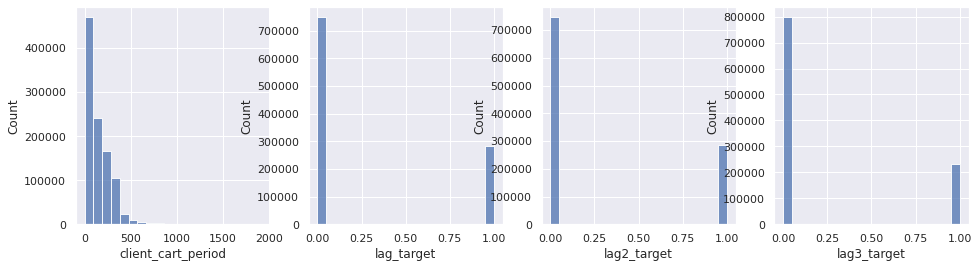

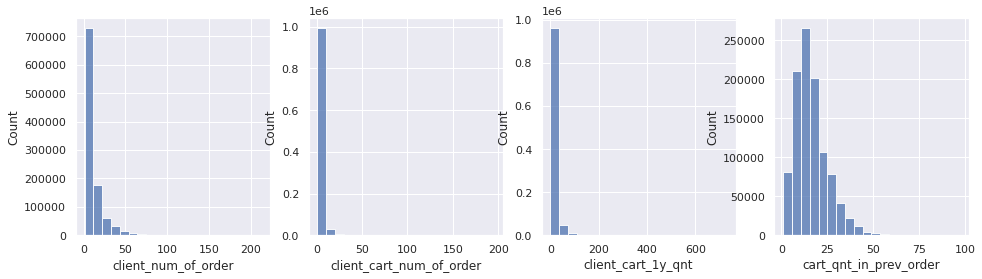

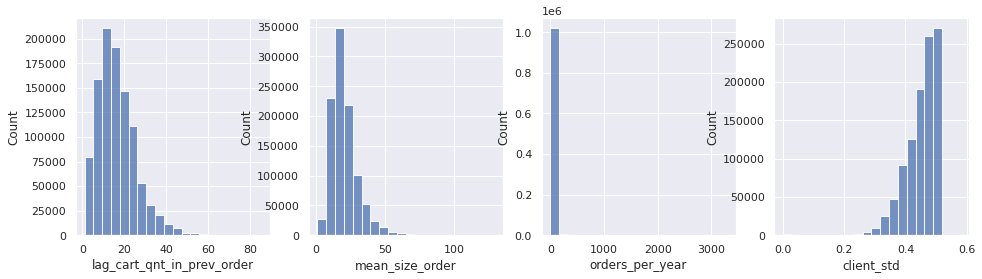

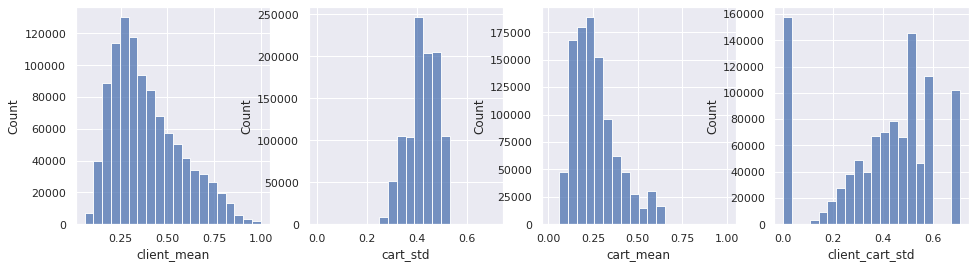

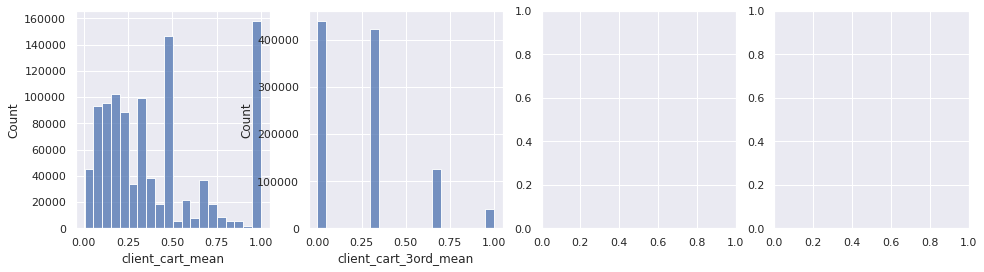

In [129]:
# Для численных признаков строим гистраграмму
sns.set_theme(style="darkgrid", palette="deep")
for k in range(0,20,4):
  fig, axes = plt.subplots(1, 4, figsize=(16,4))
  for i, column in enumerate(num_cols1[k:k+4]):
    sns.histplot(x = column, data=data, ax=axes[i], bins = 20)

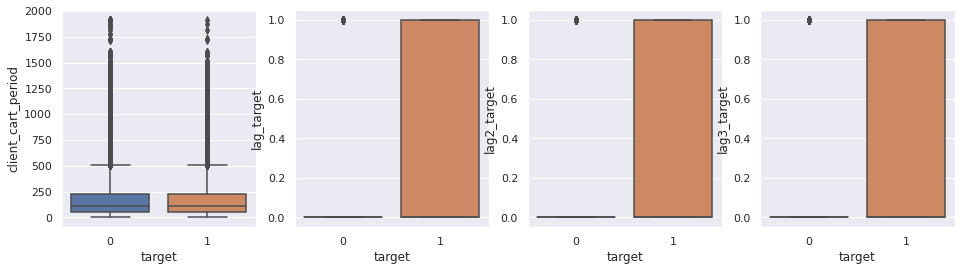

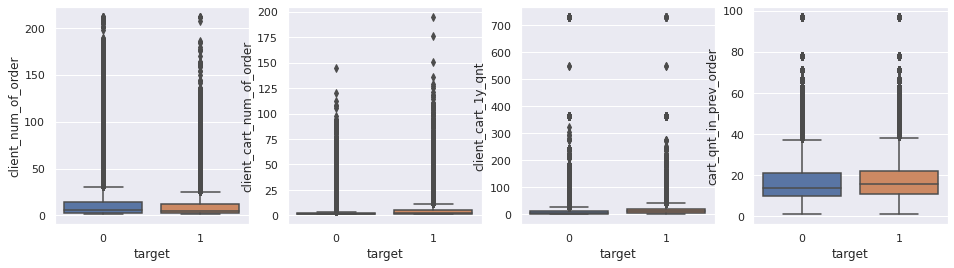

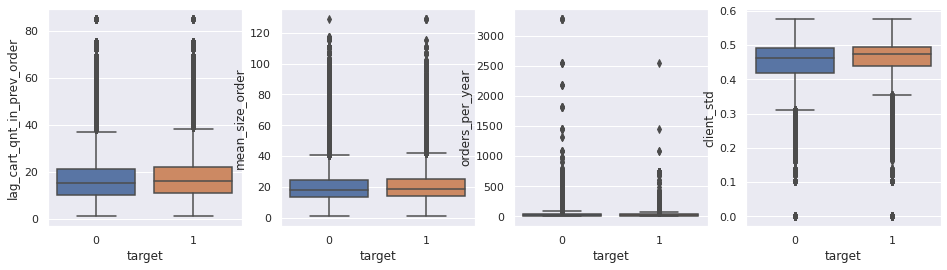

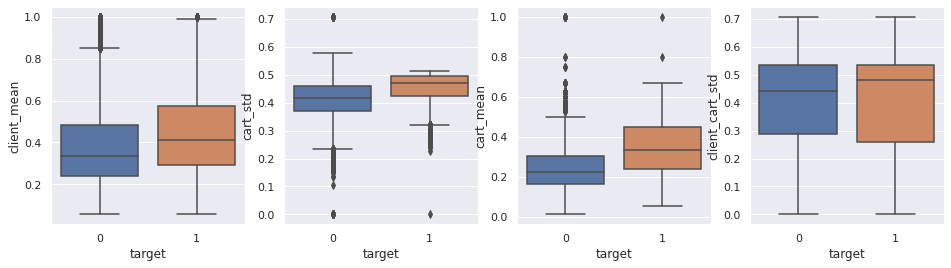

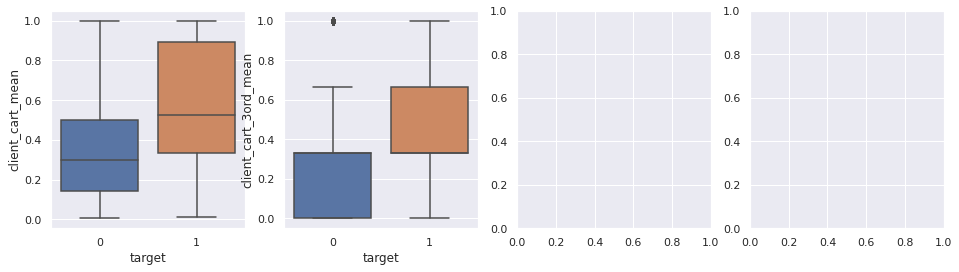

In [130]:
# Для численных признаков строим боксплоты
sns.set_theme(style="darkgrid", palette="deep")
for k in range(0,20,4):
  fig, axes = plt.subplots(1, 4, figsize=(16,4))
  for i, column in enumerate(num_cols1[k:k+4]):
    sns.boxplot(x='target', y = column, data=data, ax=axes[i])

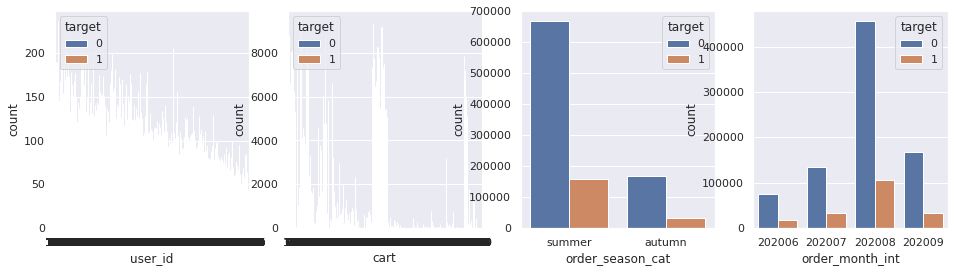

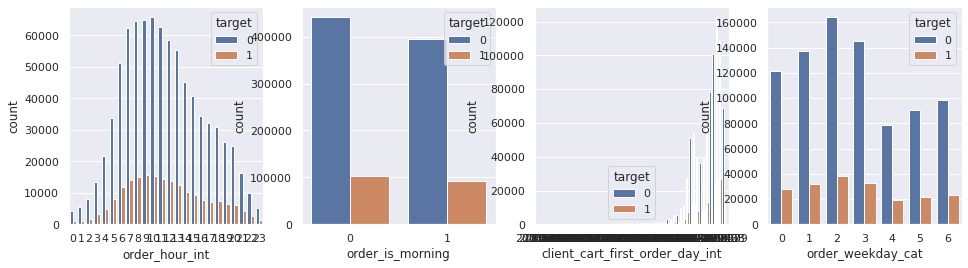

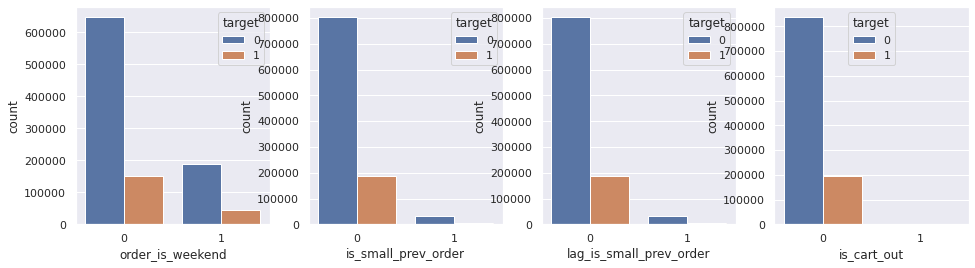

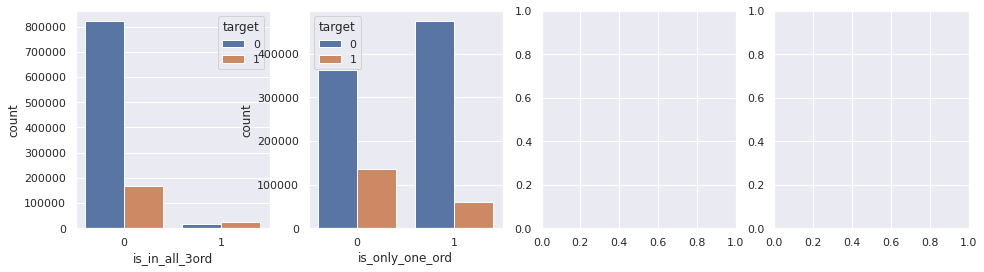

In [131]:
# Для категориальных признаков строим каунтплоты
sns.set_theme(style="darkgrid", palette="deep")
for k in range(0,16,4):
  fig, axes = plt.subplots(1, 4, figsize=(16,4))
  for i, column in enumerate(cat_cols1[k:k+4]):
    sns.countplot(x=column, hue='target', data=data, ax=axes[i])

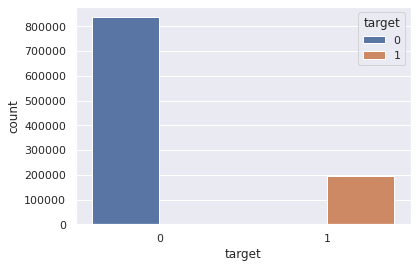

In [133]:
# Посмотриv на распределение целевой переменной, классы не сбалансированы 
sns.set_theme(style="darkgrid", palette="deep")
sns.countplot(x=target_col, hue='target', data=data)

In [136]:
# Корреляции
data.loc[:, num_cols1 + cat_cols1 + [target_col]].corr()

,client_cart_period,lag_target,lag2_target,lag3_target,client_num_of_order,client_cart_num_of_order,client_cart_1y_qnt,cart_qnt_in_prev_order,lag_cart_qnt_in_prev_order,mean_size_order,orders_per_year,client_std,client_mean,cart_std,cart_mean,client_cart_std,client_cart_mean,client_cart_3ord_mean,user_id,cart,order_month_int,order_hour_int,order_is_morning,client_cart_first_order_day_int,order_weekday_cat,order_is_weekend,is_small_prev_order,lag_is_small_prev_order,is_cart_out,is_in_all_3ord,is_only_one_ord,target
client_cart_period,1.000000,-0.146595,-0.086648,0.005223,0.522705,0.355256,-0.280375,0.037893,0.061277,-0.102538,-0.225074,-0.202887,-0.337319,0.002646,0.007461,0.027034,-0.310341,-0.125343,-0.610943,-0.003307,0.016122,0.043428,-0.026316,-0.898547,-0.009038,0.000591,0.005232,0.011675,0.001546,0.039715,-0.302898,-0.000123
lag_target,-0.146595,1.000000,0.085789,0.062807,-0.174818,0.160800,0.302930,0.195606,0.020061,0.278150,-0.030436,0.059435,0.352779,0.228386,0.254229,-0.521888,0.740117,0.627910,0.140616,-0.073867,-0.080446,0.000624,-0.003136,0.098262,0.021418,0.013206,-0.093173,-0.009003,-0.002296,0.334514,-0.183870,0.234672
lag2_target,-0.086648,0.085789,1.000000,0.079820,-0.157442,0.165171,0.094958,0.024693,0.196031,0.017661,-0.080112,0.144363,0.310999,0.227135,0.251986,0.239465,0.379380,0.637840,0.136446,-0.071877,-0.085140,0.001293,-0.000694,0.063802,0.018564,0.012525,-0.004032,-0.092277,0.000228,0.332772,-0.197598,0.208164
lag3_target,0.005223,0.062807,0.079820,1.000000,-0.074124,0.225480,0.031624,0.028702,0.035572,-0.031249,-0.072869,0.207737,0.081494,0.197986,0.218309,0.206255,0.189441,0.592813,0.045838,-0.062598,-0.029543,0.003079,-0.003748,-0.000512,0.009265,0.007230,-0.004044,-0.013243,-0.002316,0.380092,-0.254946,0.181505
client_num_of_order,0.522705,-0.174818,-0.157442,-0.074124,1.000000,0.528338,-0.103486,-0.042666,-0.040990,-0.209548,0.266811,-0.549036,-0.565282,-0.054819,-0.046343,-0.098376,-0.420420,-0.220562,-0.342408,0.004839,0.215889,0.014601,-0.004975,-0.442051,-0.057511,-0.040750,-0.000197,0.008153,0.000147,0.002287,-0.323878,-0.043755
client_cart_num_of_order,0.355256,0.160800,0.165171,0.225480,0.528338,1.000000,0.098785,0.057867,0.055281,-0.064855,0.081653,-0.181938,-0.252761,0.257006,0.287169,0.063861,0.110710,0.294994,-0.183076,-0.092256,0.108452,0.013139,-0.005069,-0.307821,-0.029670,-0.019591,-0.024999,-0.022083,-0.002286,0.287792,-0.462495,0.212926
client_cart_1y_qnt,-0.280375,0.302930,0.094958,0.031624,-0.103486,0.098785,1.000000,-0.005839,-0.036323,0.101614,0.679306,0.011856,0.154912,0.096547,0.108181,-0.192482,0.386056,0.234609,0.272228,-0.034247,-0.001619,-0.015835,0.011775,0.198693,0.007028,0.004741,-0.010332,0.007123,-0.000609,0.084541,0.002160,0.077945
cart_qnt_in_prev_order,0.037893,0.195606,0.024693,0.028702,-0.042666,0.057867,-0.005839,1.000000,0.439693,0.654373,-0.104975,0.102949,0.217094,-0.044279,-0.046956,-0.083738,0.141525,0.135619,-0.052451,0.006839,-0.013485,0.039122,-0.037973,-0.034072,0.002328,0.003292,-0.307946,-0.117929,0.000543,0.082067,-0.065317,0.060658
lag_cart_qnt_in_prev_order,0.061277,0.020061,0.196031,0.035572,-0.040990,0.055281,-0.036323,0.439693,1.000000,0.610489,-0.113116,0.213782,0.156317,-0.046596,-0.049121,0.059710,0.076159,0.137067,-0.066950,0.008685,-0.026412,0.037409,-0.030262,-0.056837,-0.007021,-0.001635,-0.112127,-0.303524,-0.001352,0.079435,-0.064875,0.053866
mean_size_order,-0.102538,0.278150,0.017661,-0.031249,-0.209548,-0.064855,0.101614,0.654373,0.610489,1.000000,-0.128252,0.210934,0.340231,-0.092703,-0.102053,-0.216906,0.380410,0.146179,-0.012859,0.022559,-0.085664,0.048120,-0.041581,0.056015,0.008282,0.006858,-0.169829,-0.159577,0.000646,0.002433,0.139030,0.027771


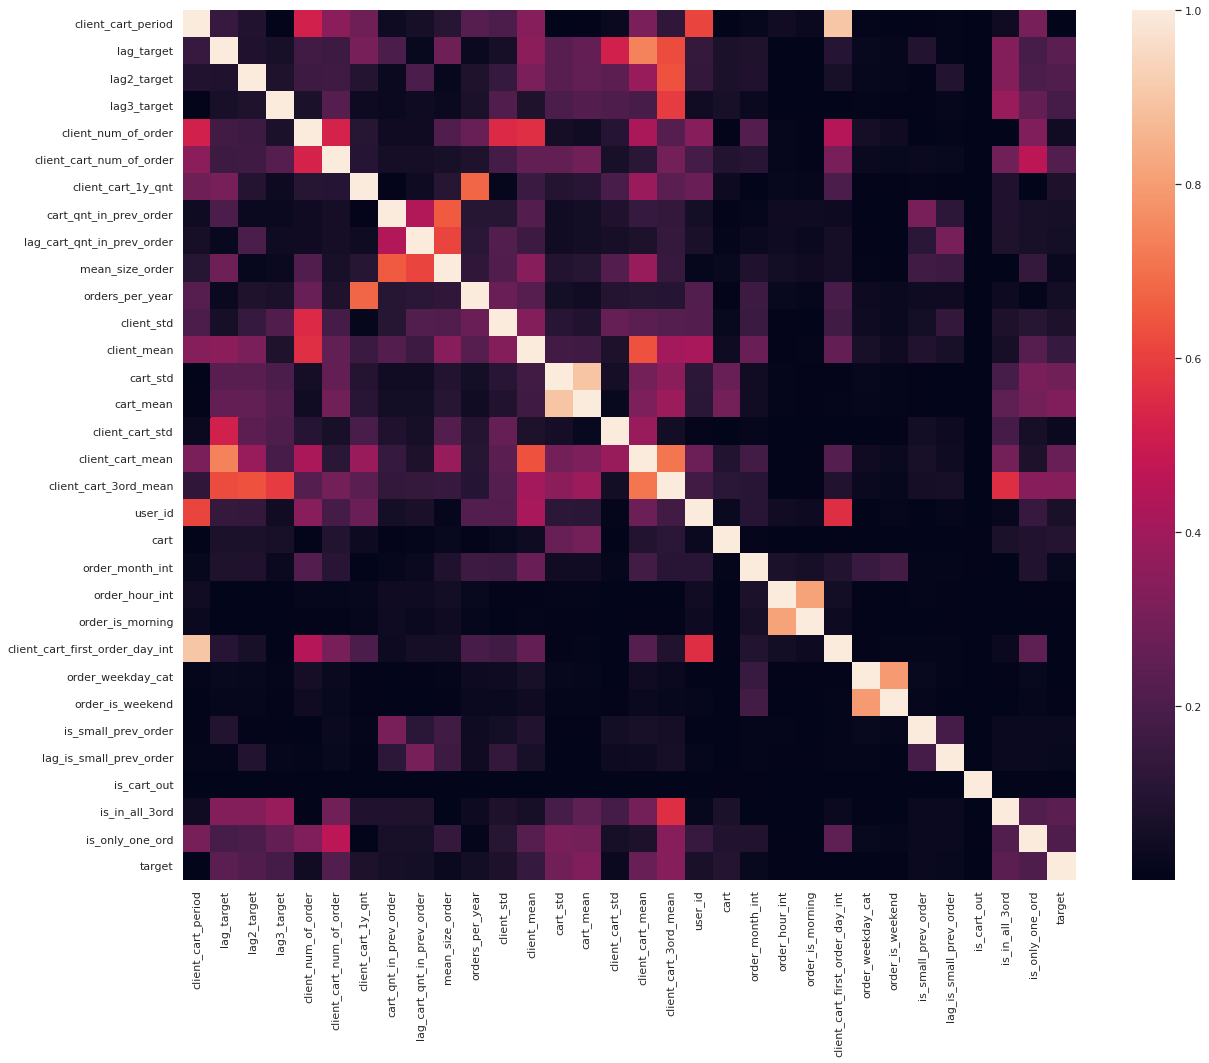

In [139]:
# Тепловой график для корреляций
plt.figure(figsize=(20,16))
sns.set_theme(style="darkgrid", palette="deep")
sns.heatmap(data.loc[:, num_cols1 + cat_cols1 + [target_col]].corr().abs())

# 4. Обучение модели

In [151]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [141]:
X_train = data[feature_cols]
X_test = test[feature_cols]
y_train = data[target_col]

#rus = RandomUnderSampler(random_state=0)
#X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [143]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_train, y_train, 
                                                       train_size=0.8, 
                                                       random_state=1,
                                                       shuffle=False)

In [149]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_cols1),
    ('scaling', StandardScaler(), num_cols1),
    ('poly', PolynomialFeatures(degree=2), num_cols1)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(solver = 'liblinear', random_state=42, penalty = 'l1'))
])

model = pipeline.fit(X_train, y_train)

In [153]:
y_pred = model.predict(X_train)
f1_score(y_train, y_pred)

0.4297802714830446

In [155]:
y_valid = model.predict(valid)

In [156]:
valid['id'] = valid['user_id'].apply(lambda x: str(x)) + ';' + valid['cart'].apply(lambda x: str(x)) 
valid = valid.set_index('id')
#test.drop(['user_id','cart'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [157]:
subm = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/sample_submission.csv")

In [162]:
valid['y_valid'] = y_valid

In [182]:
submission = subm.merge(valid['y_valid'], on = ['id'], how='left').fillna(0).set_index('id').y_valid.astype(int).rename('target')

In [183]:
submission.to_csv('submission_1.csv')

In [184]:
from google.colab import files
files.download('submission_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>